In [1]:
import os
import hashlib
from pathlib import Path
import argparse

import torch
from torch.utils.data import DataLoader
import pandas as pd
import lightning.pytorch as pl
from FUCCIDataset import FUCCIDatasetInMemory, ReferenceChannelDatasetInMemory, FUCCIChannelDatasetInMemory
from LightningModules import AutoEncoder, FUCCIDataModule


In [48]:
##########################################################################################
# Set up environment and parser
##########################################################################################

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"
torch.set_float32_matmul_precision('medium')


from dataclasses import dataclass
@dataclass
class EmbeddingArgs:
    model: str
    channels: str
    data: str
args = EmbeddingArgs(
    model="/data/ishang/fucci_vae/fucci_256_512_2023_05_24_05_47/",
    channels="fucci",
    # data="/home/ishang/implicit-cell-model/FUCCI-dev-data")
    data="/data/ishang/Fucci-dataset-v3_filtered/")

devices = 8

In [49]:
if not Path(args.model).exists():
    raise ValueError("Checkpoint path does not exist.")
args.model = Path(args.model)
if not args.model.is_file():
    if args.model / "lightning_logs" in args.model.iterdir():
        args.model = args.model / "lightning_logs"
        if len(list(args.model.iterdir())) > 1:
            raise ValueError("Multiple model directories were found in lightning_logs.")
        else:
            args.model = list(args.model.iterdir())[0]
    else:
        raise ValueError("Model path does not contain lightning_logs directory.")

if not Path(args.data).exists():
    raise ValueError("Data path does not exist.")
args.data = Path(args.data)

if args.channels not in ["reference", "fucci", "total"]:
    raise ValueError("Model must be one of: reference, fucci, total")

if args.channels == "total":
    raise NotImplementedError("Total channels not trained yet.")


def img_hash(image):
    return hashlib.blake2b(image.numpy().tobytes()).hexdigest()

if args.data / "index.csv" not in args.data.iterdir():
    if args.channels == "reference":
        dataset = ReferenceChannelDatasetInMemory(args.data, imsize=256)
    elif args.channels == "fucci":
        dataset = FUCCIDatasetInMemory(args.data, imsize=256)
    cache = []
    for i in range(len(dataset)):
        exp_dir, cell_index = dataset.image_exp_index(i)
        cache.append({
            "index": i,
            "hash": img_hash(dataset[i]),
            "directory": str(exp_dir[1]),
            "cell_index": cell_index
        })
    cache = pd.DataFrame(cache)
    cache.to_csv(args.data / "index.csv")

else:
    cache = pd.read_csv(args.data / "index.csv")

In [4]:
model = AutoEncoder.load_from_checkpoint(args.model)
dm = FUCCIDataModule(args.data, args.channels, imsize=256, batch_size=16, num_workers=8)

/home/ishang/implicit-cell-model/FUCCIDataset.py:107: UserWarning: Training split /data/ishang/Fucci-dataset-v3_filtered/reference_embeddings.pt is not a directory
  warnings.warn(f"Training split {split} is not a directory")
/home/ishang/implicit-cell-model/FUCCIDataset.py:107: UserWarning: Training split /data/ishang/Fucci-dataset-v3_filtered/reference_indices.npy is not a directory
  warnings.warn(f"Training split {split} is not a directory")
/home/ishang/implicit-cell-model/FUCCIDataset.py:107: UserWarning: Training split /data/ishang/Fucci-dataset-v3_filtered/index.csv is not a directory
  warnings.warn(f"Training split {split} is not a directory")


In [5]:
import torch
from lightning.pytorch.callbacks import BasePredictionWriter

class CustomWriter(BasePredictionWriter):

    def __init__(self, output_dir, write_interval):
        super().__init__(write_interval)
        self.output_dir = output_dir

    def write_on_epoch_end(self, trainer, pl_module, predictions, batch_indices):
        # this will create N (num processes) files in `output_dir` each containing
        # the predictions of it's respective rank
        torch.save(predictions, os.path.join(self.output_dir, f"predictions_{trainer.global_rank}.pt"))

        # optionally, you can also save `batch_indices` to get the information about the data index
        # from your prediction data
        torch.save(batch_indices, os.path.join(self.output_dir, f"batch_indices_{trainer.global_rank}.pt"))


pred_writer = CustomWriter(output_dir=args.data, write_interval="epoch")

In [6]:
trainer = pl.Trainer(accelerator="gpu", devices=devices, callbacks=[pred_writer])
# trainer = pl.Trainer(accelerator="cpu", callbacks=[pred_writer])
predictions = trainer.predict(model, datamodule=dm, return_predictions=False)

# add predictions to cache under name f"{channel}_embedding"
if f"{args.channels}_embedding" not in cache.columns:
    cache[f"{args.channels}_embedding"] = None

# for batch in predictions:
#     for i, image in enumerate(batch):
#         cache.loc[cache["index"] == i, f"{args.channels}_embedding"] = image.numpy().tolist()
# dataloader = DataLoader(dataset, batch_size=16, num_workers=8, persistent_workers=True, shuffle=False)
# with torch.no_grad():
    # for batch in iter(dm.predict_dataloader()):
    # for batch in iter(dataloader):
    #     batch.to("cuda")
    #     predictions = model(batch)
    #     print(predictions.shape)
    #     for i, embedding in enumerate(predictions):
    #         print(i)
    #         print(embedding)
    #         image = batch[i]
    #         cache.loc[cache["hash"] == img_hash(image), f"{args.channels}_embedding"] = embedding.numpy().tolist()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/8
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/8
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/8
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/8
Initializing distributed: GLOBAL_RANK: 4, MEMBER: 5/8
Initializing distributed: GLOBAL_RANK: 6, MEMBER: 7/8
Initializing distributed: GLOBAL_RANK: 5, MEMBER: 6/8
Initializing distributed: GLOBAL_RANK: 7, MEMBER: 8/8
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 8 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 4 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 

Predicting: 0it [00:00, ?it/s]

In [7]:
predictions_0 = torch.load(args.data / "predictions_0.pt")
batch_indices_0 = torch.load(args.data / "batch_indices_0.pt")
print(len(predictions_0))
print(len(predictions_0[0]))
print(len(predictions_0[1]))
print(predictions_0[0][0].shape)
print(predictions_0[0][1].shape)
print(batch_indices_0[0])

436
2
2
torch.Size([16, 2, 256, 256])
torch.Size([16, 2, 512])
[[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120], [128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248], [256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336, 344, 352, 360, 368, 376], [384, 392, 400, 408, 416, 424, 432, 440, 448, 456, 464, 472, 480, 488, 496, 504], [512, 520, 528, 536, 544, 552, 560, 568, 576, 584, 592, 600, 608, 616, 624, 632], [640, 648, 656, 664, 672, 680, 688, 696, 704, 712, 720, 728, 736, 744, 752, 760], [768, 776, 784, 792, 800, 808, 816, 824, 832, 840, 848, 856, 864, 872, 880, 888], [896, 904, 912, 920, 928, 936, 944, 952, 960, 968, 976, 984, 992, 1000, 1008, 1016], [1024, 1032, 1040, 1048, 1056, 1064, 1072, 1080, 1088, 1096, 1104, 1112, 1120, 1128, 1136, 1144], [1152, 1160, 1168, 1176, 1184, 1192, 1200, 1208, 1216, 1224, 1232, 1240, 1248, 1256, 1264, 1272], [1280, 1288, 1296, 1304, 1312, 1320, 1328, 1336, 1344, 1352, 1360, 1368, 1376, 1384, 1392, 1400]

In [8]:
# predictions are a list of tensors, each tensor is the predictions of a batch
# batch_indices are is a list of list of lists, each list of lists is the batch indices of an epoch
# for prediction we will only have one epoch, so we only need the first list of lists

predictions = []
embeddings = []
batch_indices = []
for i in range(devices):
    predictions.append(torch.load(args.data / f"predictions_{i}.pt"))
    batch_indices.append(torch.load(args.data / f"batch_indices_{i}.pt")[0])

def flatten_one(l):
    return [item for sublist in l for item in sublist]

print(len(predictions))
print(len(batch_indices))

predictions = flatten_one(predictions)
batch_indices = flatten_one(batch_indices)
print(len(predictions))
print(len(batch_indices))

print(predictions[1][0].shape)

embeddings = []
for batch in predictions:
    embeddings.append(batch[1])
print(len(embeddings))
embeddings = flatten_one(embeddings)
batch_indices = flatten_one(batch_indices)
print(len(embeddings))
print(len(batch_indices))

8
8
3488
3488
torch.Size([16, 2, 256, 256])
3488
55777
55777


In [9]:
import numpy as np
embeddings = torch.stack(embeddings)
print(embeddings.shape)
torch.save(embeddings, args.data / f"{args.channels}_embeddings.pt")
np.save(args.data / f"{args.channels}_indices.npy", np.asarray(batch_indices))

torch.Size([55777, 2, 512])


In [10]:
# remove the batch_indices_*.pt and predictions_*.pt files
for i in range(devices):
    os.remove(args.data / f"predictions_{i}.pt")
    os.remove(args.data / f"batch_indices_{i}.pt")

In [50]:
import numpy as np

predictions = torch.load(args.data / f"{args.channels}_embeddings.pt")
indices = np.load(args.data / f"{args.channels}_indices.npy")

# Update the cache file maybe? Maybe order the predictions or something so you don't need an indices file?

[2.31497124e-01 9.87088382e-02 5.80555871e-02 5.17476685e-02
 4.73623015e-02 2.96677407e-02 2.77249813e-02 2.69382950e-02
 2.15919632e-02 2.01111659e-02 1.58766303e-02 1.54339019e-02
 1.46174738e-02 1.37688853e-02 1.35460682e-02 1.19756274e-02
 1.13858776e-02 1.10184643e-02 8.83465353e-03 8.56626965e-03
 8.51984043e-03 8.24172888e-03 7.90296402e-03 7.77747622e-03
 7.43313367e-03 6.84972759e-03 6.68015005e-03 6.49584737e-03
 6.39453996e-03 6.07146136e-03 5.94918430e-03 5.77413151e-03
 5.54859918e-03 5.27301710e-03 4.90792468e-03 4.83159721e-03
 4.78305202e-03 4.61762957e-03 4.18289332e-03 4.12568310e-03
 3.97296390e-03 3.86689324e-03 3.75152775e-03 3.58944433e-03
 3.53981229e-03 3.50625184e-03 3.43881501e-03 3.24765593e-03
 3.18872347e-03 3.16502783e-03 2.94724992e-03 2.88137165e-03
 2.77465046e-03 2.66602961e-03 2.52119731e-03 2.47207843e-03
 2.43675523e-03 2.32893159e-03 2.26258067e-03 2.18853541e-03
 2.18135095e-03 2.10773433e-03 2.03162641e-03 1.99656514e-03
 1.92854158e-03 1.891490

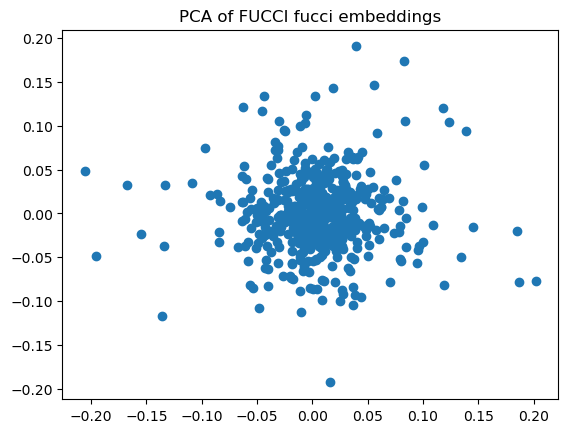

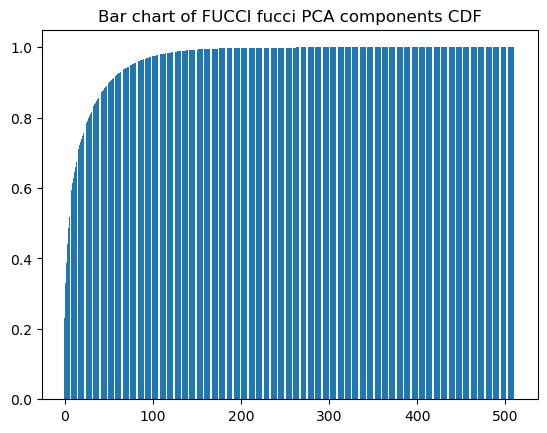

In [75]:
# select 100 random elements and do PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

indices = np.random.choice(len(predictions), 5000)
embeddings = predictions[indices, 0, :].numpy()
pca = PCA(n_components=512)
pca.fit(embeddings)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.components_.shape)

# plot the first 2 components
plt.clf()
plt.title(f"PCA of FUCCI {args.channels} embeddings")
plt.scatter(pca.components_[0], pca.components_[1])
plt.show()

plt.clf()
plt.title(f"Bar chart of FUCCI {args.channels} PCA components CDF")
plt.bar(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [43]:
import multiscale_phate
import scprep

mp_op = multiscale_phate.Multiscale_PHATE()
mp_embedding, mp_clusters, mp_sizes = mp_op.fit_transform(predictions[:, 0, :].numpy())


Calculating Multiscale PHATE tree...
  Calculating PCA...
  Calculated PCA in 1.19 seconds.
  Calculating diffusion potential...


/home/ishang/.local/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 8535 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


  Calculated diffusion potential in 1007.89 seconds.
  Setting epsilon to 0.7861
  Setting merge threshold to 0.0338
  Calculating condensation...
  Calculated condensation in 339.54 seconds.
Calculated Multiscale PHATE tree in 1373.01 seconds.
Computing gradient...
Identifying salient levels of resolution...


<Axes: xlabel='Multiscale PHATE1', ylabel='Multiscale PHATE2'>

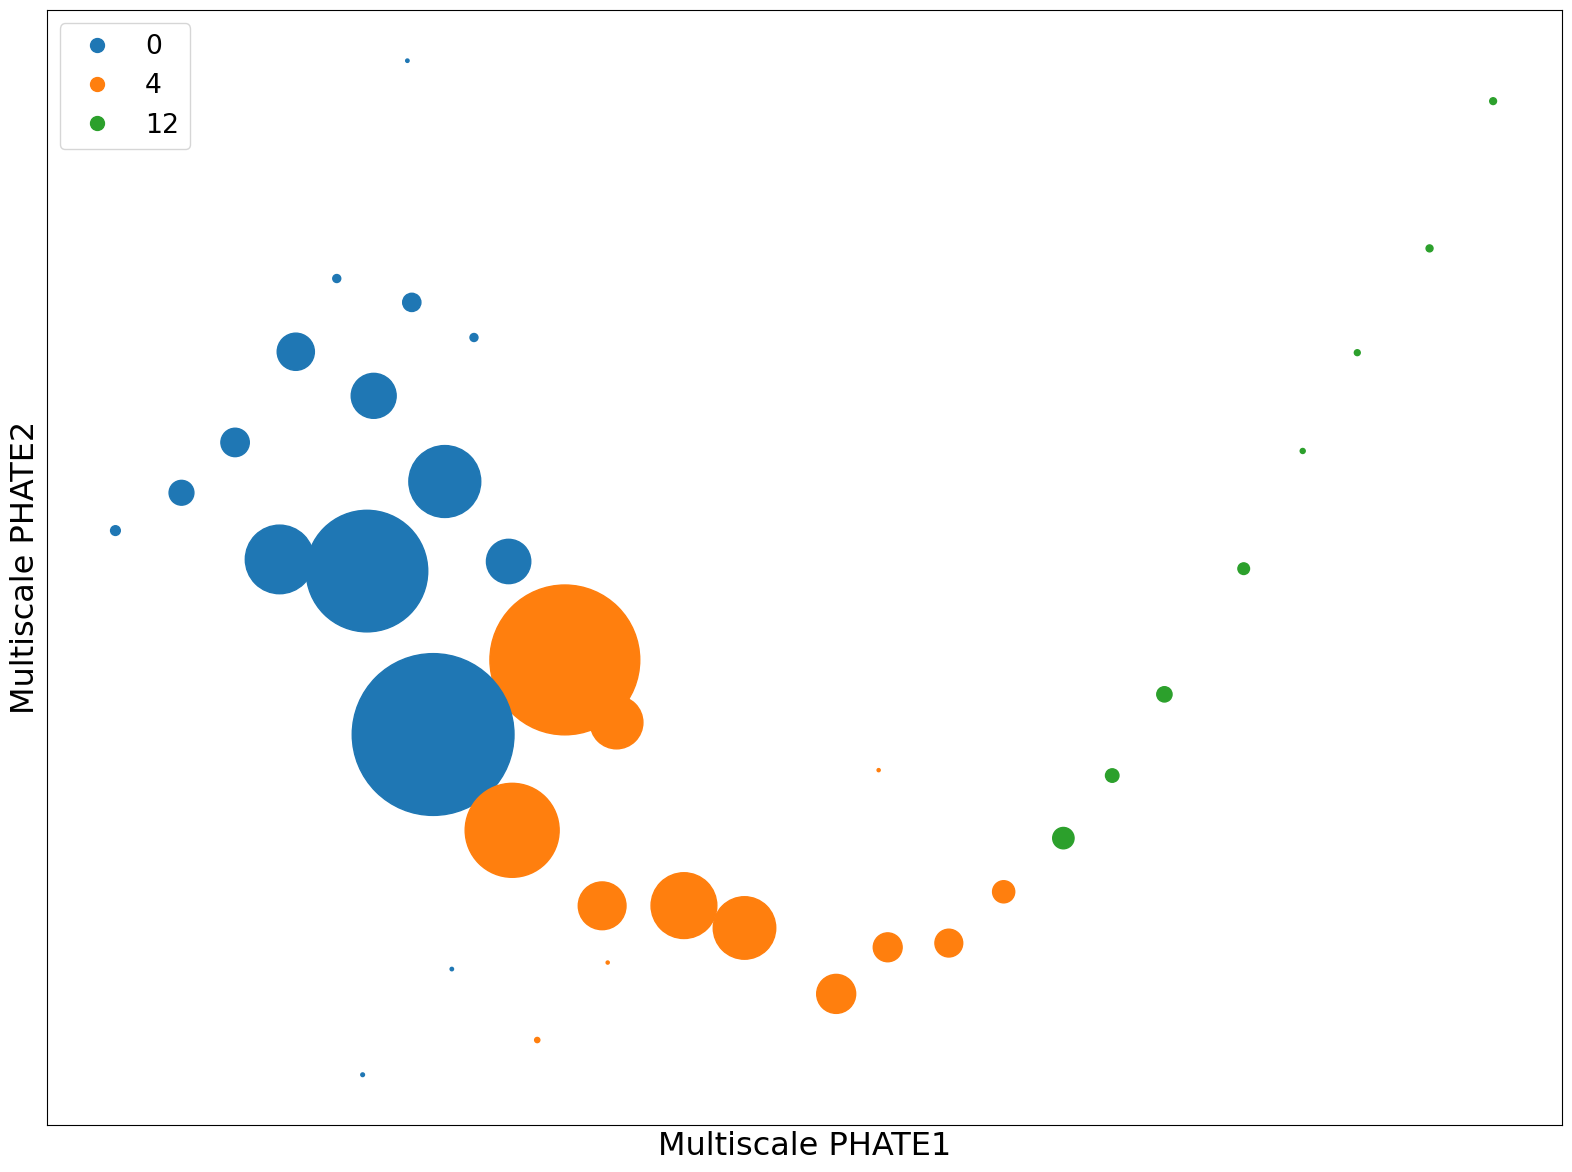

In [44]:
# Plot optimal visualization
scprep.plot.scatter2d(mp_embedding, s = mp_sizes, c = mp_clusters,
                      fontsize=16, ticks=False,label_prefix="Multiscale PHATE", figsize=(16,12))

Calculating Multiscale PHATE tree...
  Calculating PCA...
  Calculated PCA in 0.11 seconds.
  Calculating diffusion potential...


/home/ishang/.local/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 279 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


  Calculated diffusion potential in 9.22 seconds.
  Setting epsilon to 0.1629
  Setting merge threshold to 0.001
  Calculating condensation...
  Calculated condensation in 31.80 seconds.
Calculated Multiscale PHATE tree in 41.35 seconds.
Computing gradient...
Identifying salient levels of resolution...


<Axes: xlabel='Multiscale PHATE1', ylabel='Multiscale PHATE2'>

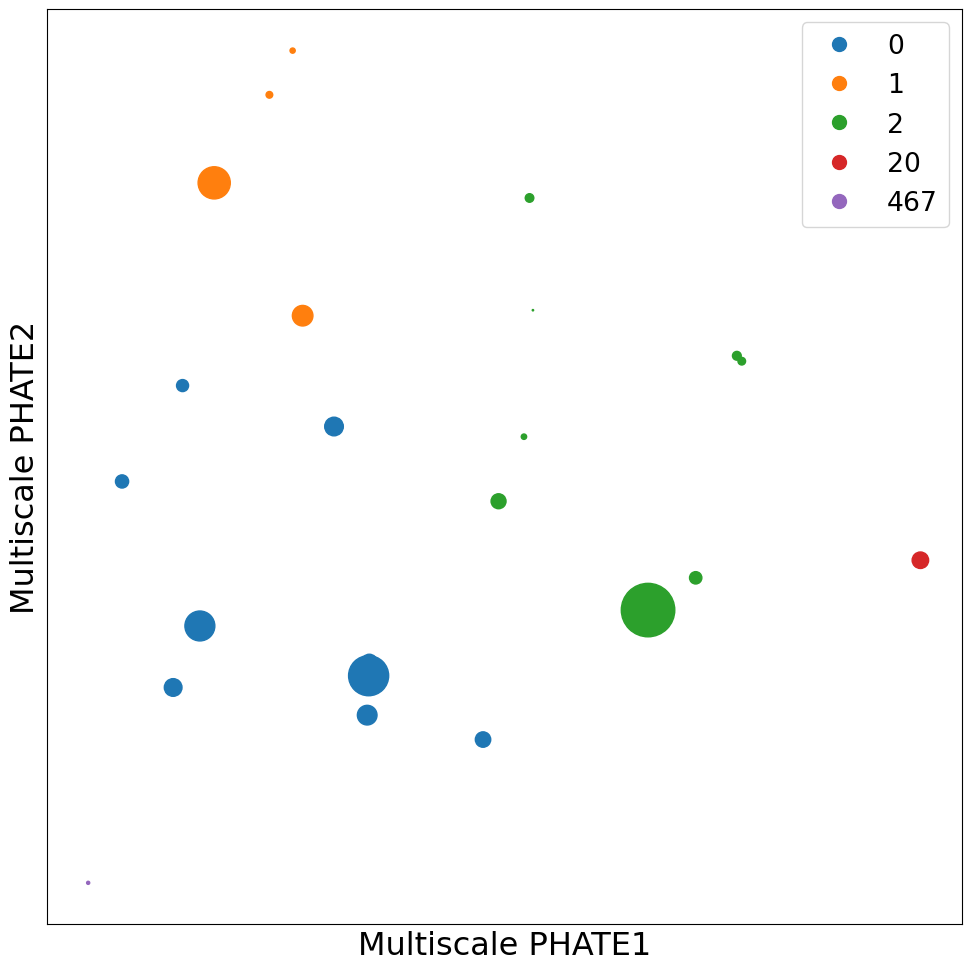

In [66]:
mp_op = multiscale_phate.Multiscale_PHATE()
mp_embedding, mp_clusters, mp_sizes = mp_op.fit_transform(embeddings)
scprep.plot.scatter2d(mp_embedding, s = mp_sizes,
                      fontsize=16, ticks=False,label_prefix="Multiscale PHATE", figsize=(10,10))

(5000, 4, 256, 256)
-20.384209 18.889896


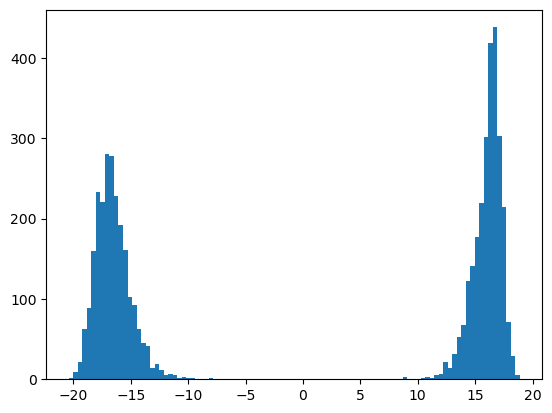

<Figure size 640x480 with 0 Axes>

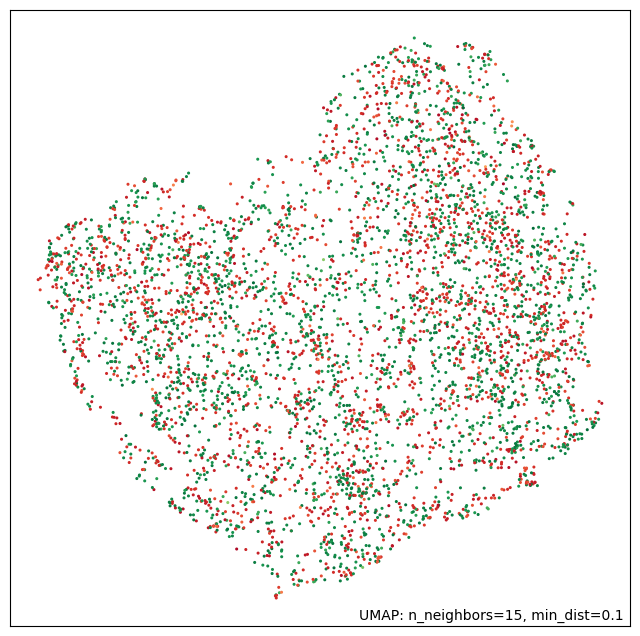

In [76]:
# plot UMAP of 100 samples

import umap
import umap.plot

umap_embedding = umap.UMAP().fit(embeddings)
if args.channels == "fucci":
    if dataset is None:
        dataset = FUCCIDatasetInMemory(args.data, imsize=256)
    colors = dataset[indices].numpy()
    print(colors.shape)
    colors = colors[:, 0, :, :] - colors[:, 1, :, :]
    # colors = np.sum(colors, axis=(1, 2)) / (colors.shape[1] * colors.shape[2])
    colors = np.sum(colors, axis=(1, 2))
    colors = np.sign(colors) * np.log(np.abs(colors) + 1e-8)
    print(colors.min(), colors.max())
    plt.clf()
    plt.hist(colors, bins=100)
    plt.show()
    plt.clf()
    # plot gradient of red to green for small to large
    umap.plot.points(umap_embedding, values=colors, cmap="RdYlGn")
else:
    umap.plot.points(umap_embedding)

In [86]:
mp_op = multiscale_phate.Multiscale_PHATE()
emb = embeddings
cols = colors
# mp_embedding, mp_clusters, mp_sizes = mp_op.fit_transform(embeddings)
levels = mp_op.fit(emb)


Calculating Multiscale PHATE tree...
  Calculating PCA...
  Calculated PCA in 0.09 seconds.
  Calculating diffusion potential...


/home/ishang/.local/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 277 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


  Calculated diffusion potential in 9.80 seconds.
  Setting epsilon to 0.1846
  Setting merge threshold to 0.001
  Calculating condensation...
  Calculated condensation in 30.64 seconds.
Calculated Multiscale PHATE tree in 40.74 seconds.
Computing gradient...
Identifying salient levels of resolution...


In [88]:
levels

[0, 2, 130, 146, 153, 163]

<Axes: xlabel='Multiscale PHATE1', ylabel='Multiscale PHATE2'>

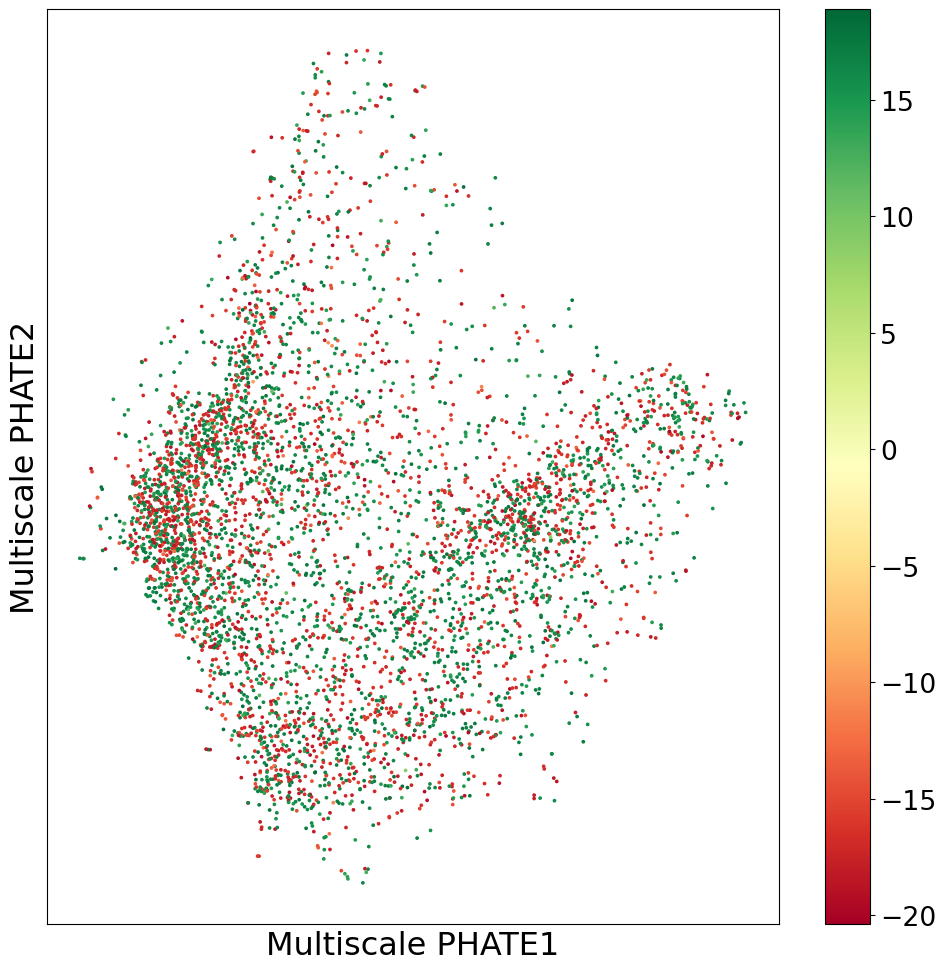

In [89]:
mp_embedding, mp_clusters, mp_sizes = mp_op.transform(visualization_level = levels[0],
                                                                  cluster_level = levels[0])
scprep.plot.scatter2d(mp_embedding, cmap="RdYlGn", c=cols, fontsize=16, ticks=False, label_prefix="Multiscale PHATE", figsize=(10,10))